<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/NLP_Sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment of movie reviews classification

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('./LargeMovieReviewDataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Exploring the Data**

In [ ]:
df.review.loc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Mean review length:  768.75412
Min review length:  18
Max review length:  8529


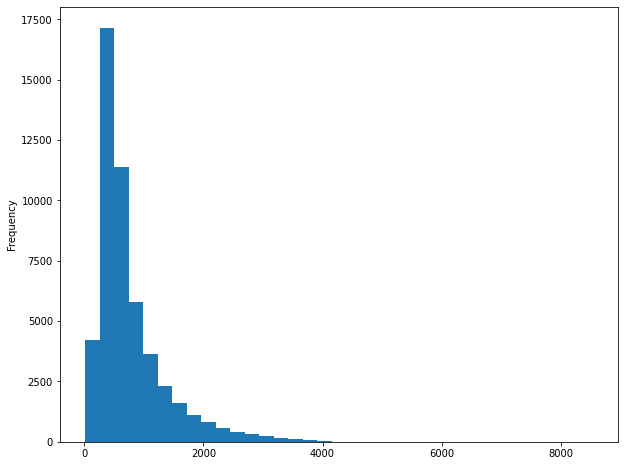

In [ ]:
df['review_length'] = df.review.apply(len)
print("Mean review length: ", df['review_length'].mean())
print("Min review length: ", df['review_length'].min())
print("Max review length: ", df['review_length'].max())
df.review_length.plot.hist(bins=35)

Most of reviews have length between 250 and 1500 symbols.

In [ ]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
sw = STOPWORDS
sw.add('br')

I'm going to try the WordCloud tool to find out which words are the most in two target classes - negative and positive reviews.

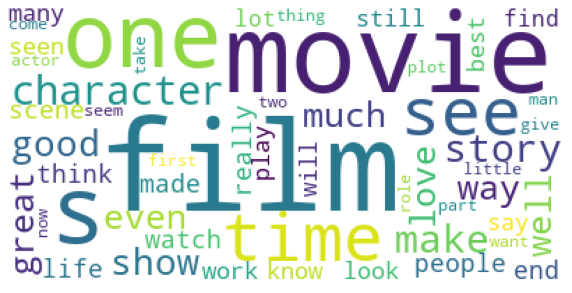

In [ ]:
text = list(df[df['sentiment'] == 'positive'].review.values)

wordcloud = WordCloud(background_color ='white', stopwords=sw, min_font_size = 10).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

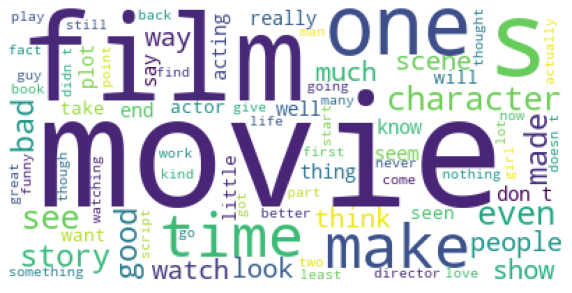

In [ ]:
text = list(df[df['sentiment'] == 'negative'].review.values)

wordcloud = WordCloud(background_color ='white', stopwords=sw, min_font_size = 10).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Actually, WordCloud didn't give any helpful information about our data. Both clouds seem very similar because the vast majority of the most used words are common between the two classes. So I would use WordCloud later after cleaning the data and filtering common words.

In [ ]:
df[df['review_length']==32].review

27521    Read the book, forget the movie!
Name: review, dtype: object

Function that removes all punctuation signs from the given string:

In [ ]:
def remove_punct(text):
  return "".join([char if char not in string.punctuation else ' ' for char in text])

Function that counts statistics from all the texts from the given column(pd.Series) and returns it as a DataFrame:  

In [ ]:
def get_stats(col):
  result = pd.DataFrame(columns=['length', 'word_count', 'avg_word_len', 'letters_count',
                                 'spaces_count', 'digits_count', 'capitals_count', 'punct_signs_count'])


  for i in range(len(col)):
    res_dict = {}
    text = col[i]
    if type(text)==list:
      text = ' '.join(text)
    letters = re.compile('[a-zA-Z]')
    digits = re.compile('[0-9]')
    capitals = re.compile('[A-Z]')
    pntc = r"[!\"#\$%&\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]"

    words = remove_punct(text).lower().split()
    average_length = sum(len(word) for word in words) / len(words)
    spaces_cnt = text.count(' ')
    letters_cnt = len(re.findall(letters, text))
    digits_cnt = len(re.findall(digits, text))
    capitals_cnt = len(re.findall(capitals, text))
    punct_cnt = len(re.findall(pntc, text))

    res_dict.update({'length': len(text), 'word_count': len(words), 'avg_word_len': average_length, 'letters_count': letters_cnt,
                     'spaces_count': spaces_cnt, 'digits_count': digits_cnt, 'capitals_count': capitals_cnt, 'punct_signs_count': punct_cnt})
    result = result.append(res_dict, ignore_index=True)

  return result

Getting stats for all the reviews in our dataset:

In [ ]:
stats = get_stats(df['review'])

In [ ]:
stats.head()

,length,word_count,avg_word_len,letters_count,spaces_count,digits_count,capitals_count,punct_signs_count
0,1761.0,320.0,4.303125,1376.0,306.0,1.0,43.0,78.0
1,998.0,166.0,4.777108,793.0,161.0,0.0,16.0,44.0
2,926.0,172.0,4.191860,720.0,165.0,1.0,23.0,40.0
3,748.0,141.0,4.035461,566.0,137.0,3.0,24.0,42.0
4,1317.0,236.0,4.372881,1032.0,229.0,0.0,34.0,56.0


Now we can get descriptive statistics on all our corpus:

In [ ]:
stats.describe()

,length,word_count,avg_word_len,letters_count,spaces_count,digits_count,capitals_count,punct_signs_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1309.431020,239.570400,4.258074,1023.242960,230.145940,3.233600,35.738480,52.578560
std,989.728014,177.454854,0.302484,777.688735,171.326419,5.388188,33.966999,43.922545
min,32.000000,6.000000,2.917808,25.000000,3.000000,0.000000,0.000000,0.000000
25%,699.000000,131.000000,4.055100,544.000000,125.000000,0.000000,16.000000,24.000000
50%,970.000000,179.000000,4.245921,757.000000,172.000000,2.000000,26.000000,39.000000
75%,1590.250000,291.000000,4.446618,1243.000000,279.000000,4.000000,44.000000,67.000000
max,13704.000000,2525.000000,10.400000,10862.000000,2469.000000,185.000000,749.000000,657.000000


In [ ]:
stats[stats['avg_word_len']>10]

,length,word_count,avg_word_len,letters_count,spaces_count,digits_count,capitals_count,punct_signs_count
45315,730.0,60.0,10.4,616.0,54.0,7.0,13.0,52.0


In [ ]:
stats[stats['word_count']<10]

,length,word_count,avg_word_len,letters_count,spaces_count,digits_count,capitals_count,punct_signs_count
13109,61.0,8.0,5.875000,47.0,7.0,0.0,1.0,7.0
27521,32.0,6.0,4.166667,25.0,5.0,0.0,1.0,2.0
28920,51.0,6.0,7.500000,45.0,3.0,0.0,3.0,3.0
31072,41.0,9.0,3.333333,30.0,8.0,0.0,1.0,3.0


In [ ]:
stats[stats['length']>13000]

,length,word_count,avg_word_len,letters_count,spaces_count,digits_count,capitals_count,punct_signs_count
31481,13704.0,2525.0,4.307723,10862.0,2469.0,15.0,673.0,358.0


In [ ]:
df['review'].iloc[27521]

'Read the book, forget the movie!'

In [ ]:
df['review'].iloc[45315]

".....whoops - looks like it's gonna cost you a whopping £198.00 to buy a copy (either DVD or Video format)from ITV direct.<br /><br />Ouch.<br /><br />Sorry about this, but IMDB won't let me submit this comment unless it has at least 10 lines, so...........<br /><br />blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblah !!<br /><br />"

We also can plot graphs based on these statistics:

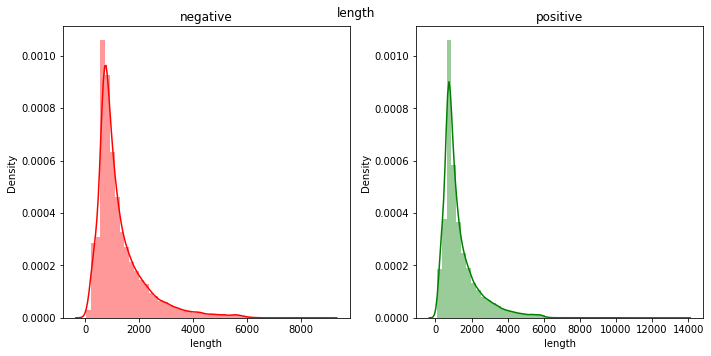

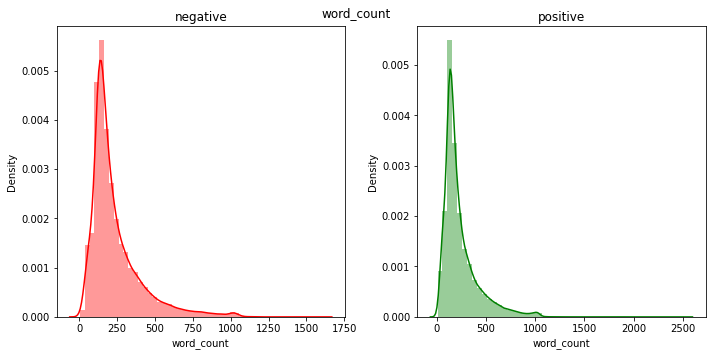

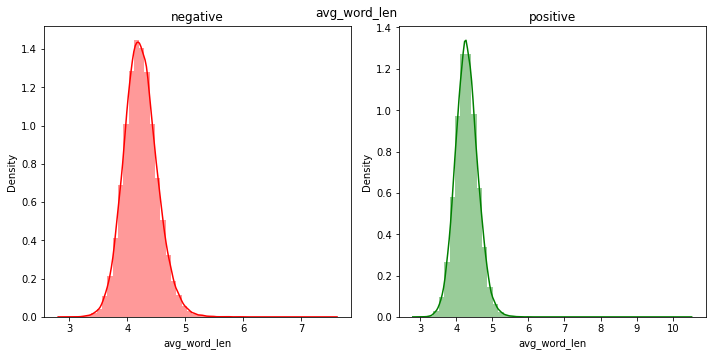

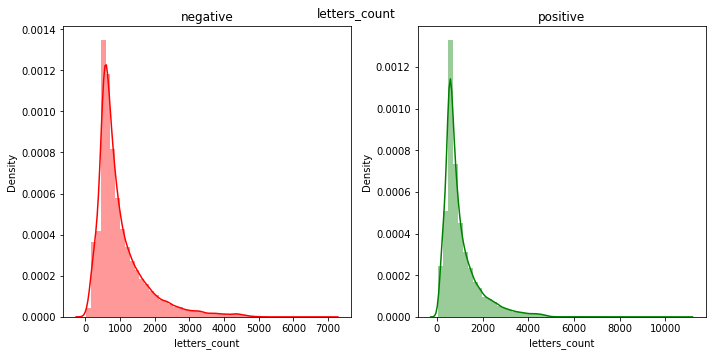

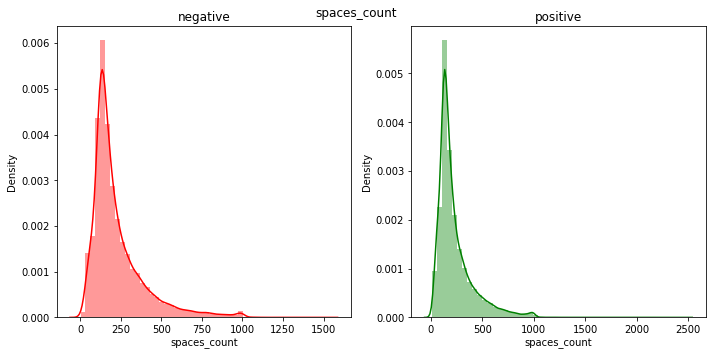

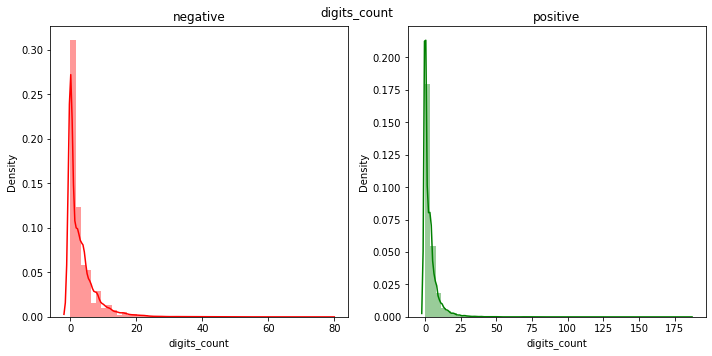

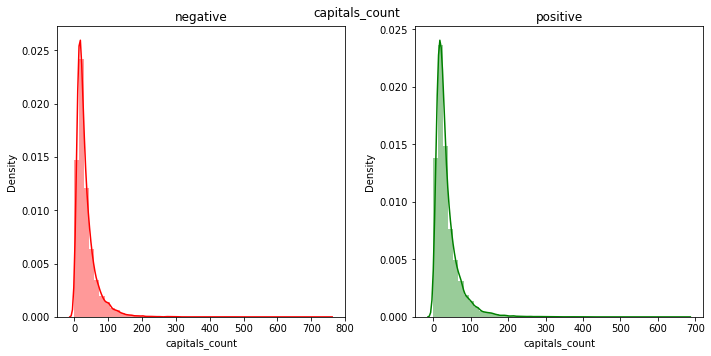

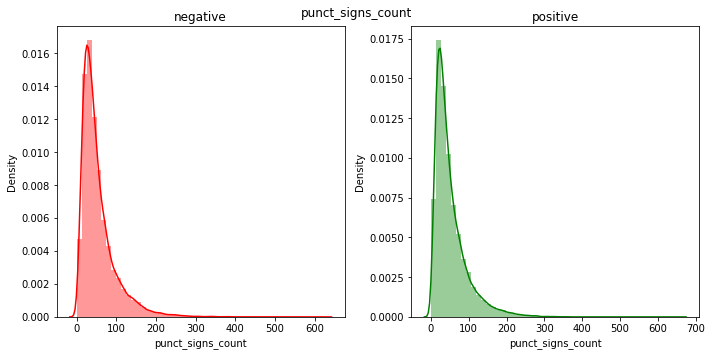

In [ ]:
for stat in stats.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
    sns.distplot(stats[df['sentiment'] == 'negative'][stat], ax=ax1, color='red')
    ax1.set_title('negative')
    sns.distplot(stats[df['sentiment'] == 'positive'][stat], ax=ax2, color='green')
    ax2.set_title('positive')
    fig.suptitle(stat)
    plt.tight_layout()

As we can see we have mainly right-skewed distributions for all statistics associated with quantities of different kinds of symbols in reviews and clear normal distribution for average word length.   

The function that counts frequencies of appearance for all the words in the given corpus:

In [ ]:
def get_corpus_statistics(col, top_num, verbose=0):
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    corpus += text
    corpus += ' '
  words = remove_punct(corpus).lower().split()
  word_counts = Counter(words)

  result = {}
  if verbose!=0:
    print('Size of vocabulary: ',len(list(word_counts)))
    print(f'Most {top_num} common words are:')
  for item in word_counts.most_common(top_num):
    result[item[0]] = int(item[1])
  return result

In [ ]:
get_corpus_statistics(df['review'][:10], 10, 1)

Size of vocabulary:  685
Most 10 common words are:


{'the': 96,
 'a': 44,
 'and': 41,
 'of': 38,
 'is': 37,
 'to': 37,
 'br': 36,
 'i': 27,
 'this': 26,
 'it': 26}

# Cleaning & Preprocessing the data

Removing extra whitespaces

In [ ]:
def remove_whitespace(text):
    return  " ".join(text.split())

Removing HTML tags

In [ ]:
def remove_tag(text):

    text=''.join(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r' ', text)

Removing numbers

In [ ]:
def remove_numbers(text):

    text=''.join(text)
    number_pattern = re.compile('\d+')
    return number_pattern.sub(r' ', text)

Removing URLs

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
    return url_pattern.sub(r'', text)

Removing stopwords

As our main task is to define the sentiment of the review I assume that the words "not" and "no" might be significant in the case of analyzing n-grams with lengths of 2 and more (N-grams like "not good", "not bad" etc. might have value in the classification task). That's why I decided to exclude these words from the stop-words list before filtering.

In [ ]:
deselect_stop_words = ['no', 'not']
sw = list(sw)
for w in sw:
  if w in deselect_stop_words:
    sw.remove(w)
sw = set(sw)

In [ ]:
def remove_stopwords(text):
    result = ""
    text = text.split()
    for word in text:
      if word not in sw:
        result += word
        result += ' '
    return result

In [ ]:
get_corpus_statistics(df['review'][:100], 10)

{'the': 1381,
 'a': 679,
 'and': 651,
 'of': 624,
 'to': 531,
 'br': 458,
 'is': 419,
 'in': 385,
 'it': 364,
 'i': 304}

Spelling Correction

Here could be spelling correction as a part of text preprocessing but it turned out to be very time-consuming so I decided to skip it.

In [ ]:
def spell_check(text):

    result = []
    spell = SpellChecker()
    for word in text:
        correct_word = spell.correction(word)
        result.append(correct_word)

    return result

Lemmatization

In [ ]:
def lemmatization(text):

    result = ""
    text = text.split()
    wordnet = WordNetLemmatizer()
    for word, tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
          pos='n'
        result += wordnet.lemmatize(word,pos)
        result += ' '
    return result

Stemming

In [ ]:
def stemming(text):
    porter = PorterStemmer()

    result = ""
    text = text.split()
    for word in text:
      result += porter.stem(word)
      result += ' '
    return result

I have done classification with both stemming and lemmatization used in text preprocessing. It gives very similar results in terms of models' performance. Although vocabulary given by stemming is significantly shorter than that lemmatization gives.  

The function that performs all preprocessing tasks on a given corpus:

In [ ]:
def preprocessing(d_frame, column, baseform_method):
  df = d_frame.copy()
  df[column] = df[column].str.lower()
  df[column] = df[column].apply(remove_tag)
  df[column] = df[column].apply(remove_numbers)
  df[column] = df[column].apply(remove_urls)
  df[column]=df[column].apply(remove_stopwords)
  df[column]=df[column].apply(remove_punct)
  df[column]=df[column].apply(remove_whitespace)
  if baseform_method == 'stemm':
    df[column]=df[column].apply(stemming)
  elif baseform_method == 'lemm':
    df[column]=df[column].apply(lemmatization)

  return df

In [ ]:
df_test = df.copy()
#df_test = df_test[:5]

In [ ]:
df= df_test.copy()

In [ ]:
df = preprocessing(df, 'review', 'lemm')
df.head()

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei s love time money visually stunn...,positive


In [ ]:
get_corpus_statistics(df[df['sentiment']=='positive']['review'], 20, 1)

Size of vocabulary:  65643
Most 20 common words are:


{'film': 50740,
 'movie': 44844,
 's': 38531,
 'not': 28300,
 'one': 28285,
 'see': 21858,
 'make': 20903,
 'time': 16430,
 'well': 15847,
 'good': 15094,
 'story': 14140,
 'character': 14025,
 'it': 13165,
 'great': 13010,
 'go': 12616,
 'watch': 12293,
 'show': 12111,
 'love': 11643,
 'think': 10855,
 'really': 10740}

In [ ]:
get_corpus_statistics(df[df['sentiment']=='negative']['review'], 20, 1)

Size of vocabulary:  62401
Most 20 common words are:


{'movie': 58425,
 'film': 44821,
 'not': 32439,
 's': 30180,
 'one': 27155,
 'make': 24648,
 'see': 19675,
 'no': 16061,
 'even': 15382,
 'time': 15225,
 'go': 14859,
 'good': 14774,
 'bad': 14726,
 'character': 14331,
 'watch': 14275,
 'it': 13797,
 'well': 12930,
 'really': 12355,
 'think': 11764,
 'look': 11699}

In [ ]:
sw.update(['s', 'm', 'b', 'd'])
df['review']=df['review'].apply(remove_stopwords)

Once again I will use WordCloud to visualize words specific to negative and positive reviews. For this, I use the function determining unique words for both classes.

In [ ]:
def get_common_words(dict1, dict2):
  dict1_set = set(dict1)
  dict2_set = set(dict2)
  result = {}
  for name in dict1_set.intersection(dict2_set):
    result[name] = dict1[name] + dict2[name]
  return result

In [ ]:
def get_unique_words(dict1, dict2):
  dict1_set = set(dict1)
  dict2_set = set(dict2)
  result = {}
  for name in dict1_set.difference(dict2_set):
    result[name] = dict1[name]
  return result

In [ ]:
pos_top = get_corpus_statistics(df[df['sentiment']=='positive']['review'], 500)
neg_top = get_corpus_statistics(df[df['sentiment']=='negative']['review'], 500)
common = get_common_words(pos_top, neg_top)
unique_pos = get_unique_words(pos_top, neg_top)
unique_neg = get_unique_words(neg_top, pos_top)

In [ ]:
len(common)

403

In [ ]:
common

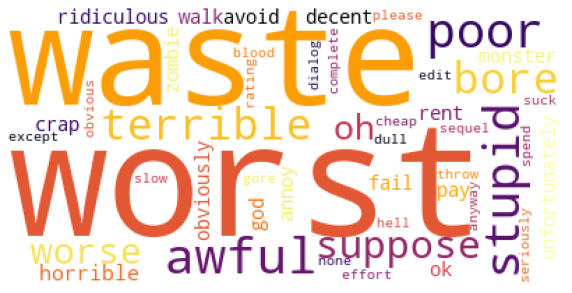

In [ ]:
wordcloud = WordCloud(background_color ='white', colormap='inferno', stopwords=sw, min_font_size = 10).generate_from_frequencies(unique_neg)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

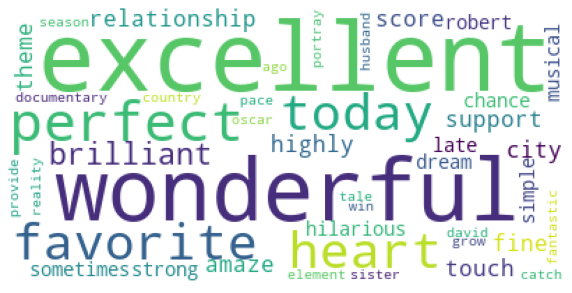

In [ ]:
wordcloud = WordCloud(background_color ='white', stopwords=sw, min_font_size = 10).generate_from_frequencies(unique_pos)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

On the clouds above we can see the words that are present uniquely in negative and positive classes respectively.

## Pipeline

Due to performance issues (GridSearchCV on SVC fitted for about 2 hours on the whole dataset) I decided to trim the dataset leaving 60% of the original number of items.  

In [ ]:
df_short = df.iloc[:30000]

In [ ]:
df_short['sentiment'].value_counts()

positive    15015
negative    14985
Name: sentiment, dtype: int64

In [ ]:
df_short

,review,sentiment
0,one review mention watch oz episod hook right ...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive
...,...,...
29995,new york love final make shore short stori lov...,positive
29996,movi make wish imdb let vote zero one two movi...,negative
29997,space camp unfortun luck plan around time chal...,negative
29998,octavio paz mexican poet writer diplomat recei...,positive


Train-test split with shuffling data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_short.drop('sentiment', axis=1), df_short['sentiment'], test_size=0.2, shuffle=True)

In [ ]:
y_train.value_counts()

positive    12009
negative    11991
Name: sentiment, dtype: int64

In [ ]:
y_test.value_counts()

positive    3006
negative    2994
Name: sentiment, dtype: int64

In [ ]:
y_train =  y_train.replace('positive',1)
y_train =  y_train.replace('negative',0)
y_test = y_test.replace('positive',1)
y_test = y_test.replace('negative',0)

In [ ]:
y_test

18135    1
12269    1
1323     1
11735    0
9058     0
        ..
13115    0
24436    0
25700    1
13085    0
21038    0
Name: sentiment, Length: 6000, dtype: int64

# Models and Hyperparameters tuning

Logistic Regression

In [ ]:
lr_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1), min_df=2)),
    ('clf', LogisticRegression())
])

parameters = {'clf__C': [0.05, 0.1, 1, 5]}

lr_gs = GridSearchCV(lr_pipe, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=0, n_jobs=-1)

In [ ]:
lr_gs.fit(X_train.review, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=2)),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1, param_grid={'clf__C': [0.05, 0.1, 1, 5]}, scoring='f1')

In [ ]:
lr_gs.best_params_

{'clf__C': 5}

In [ ]:
lr_gs.best_score_

0.8833960708399848

In [ ]:
y_pred = lr_gs.predict(X_test.review)

In [ ]:
accuracy_score(y_test, y_pred)

0.8923333333333333

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2954
           1       0.89      0.90      0.89      3046

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



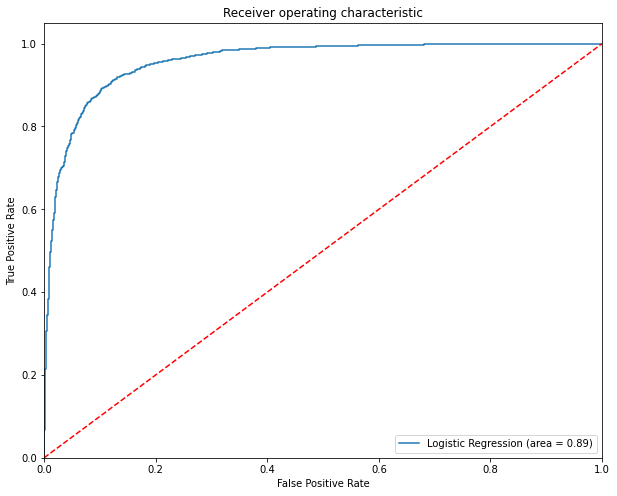

In [ ]:
logit_roc_auc = roc_auc_score(y_test, lr_gs.predict(X_test.review))
fpr, tpr, thresholds = roc_curve(y_test, lr_gs.predict_proba(X_test.review)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Logistic regression gives an accuracy score of 0.89 and the same ROC-AUC score.

**Words Importance**

In order to visualize words importances I am taking coefficients from the fitted model and feature names from vectorizer, sorted them by value and plotted top positive and negative features.

In [ ]:
importances = pd.DataFrame(data={
    'Word': lr_gs.best_estimator_.get_params()['steps'][0][1].get_feature_names(),
    'Importance': lr_gs.best_estimator_.get_params()['steps'][1][1].coef_[0]
})
importances_pos = importances.sort_values(by='Importance', ascending=False)[:20]
importances_neg = importances.sort_values(by='Importance', ascending=True)[20::-1]
importances = pd.concat([importances_pos, importances_neg])

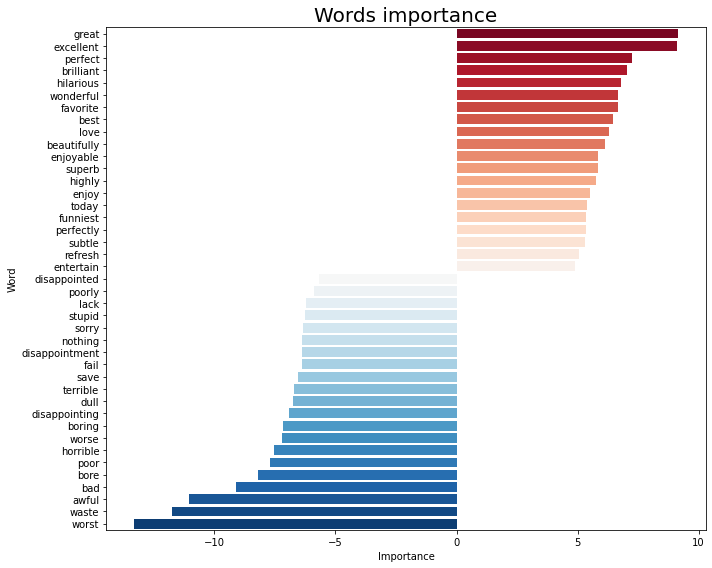

In [ ]:
sns.barplot(y=importances['Word'], x=importances['Importance'], palette='RdBu', saturation=1,  orient='h')
plt.title('Words importance', size=20)
plt.tight_layout()
plt.show()

In the plot above we can see top-20 of the most important words that Logistic Regression uses to classify reviews on their sentiment.

**Hypothesys**: The model will work better if I drop top-100 most frequent words common for both target classes.

In [ ]:
df_cleaned = df_short.copy()
for cw in common.keys():
  df_cleaned = df_cleaned.replace(cw,'')

In [ ]:
df_cleaned.shape

(30000, 2)

In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(df_cleaned.drop('sentiment', axis=1), df_cleaned['sentiment'], test_size=0.2, shuffle=True)

In [ ]:
y_train_c =  y_train.replace('positive',1)
y_train_c =  y_train.replace('negative',0)
y_test_c = y_test.replace('positive',1)
y_test_c = y_test.replace('negative',0)

In [ ]:
X_train_c.count()

review    24000
dtype: int64

In [ ]:
lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('clf', LogisticRegression(solver='lbfgs', C=5))
])
lr_pipeline.fit(X_train_c.review, y_train_c)


Pipeline(steps=[('vectorizer', TfidfVectorizer(min_df=2)),
                ('clf', LogisticRegression(C=5))])

In [ ]:
y_pred = lr_pipeline.predict(X_test_c.review)
accuracy_score(y_test_c, y_pred)

0.48883333333333334

In [ ]:
print(classification_report(y_test_c, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2954
           1       0.51      0.51      0.51      3046

    accuracy                           0.50      6000
   macro avg       0.50      0.50      0.50      6000
weighted avg       0.50      0.50      0.50      6000



Hypothesis failed - the performance of the model on the cleaned dataset reduced significantly. Common words are also necessary for the classification model probably because their frequency also varies between texts of the different target classes so they are used by the model to classify.

# Stochastic Gradient Descent

For the features extraction (vectorization) in SGD Classifier (and in others) pipeline I use TF-IDF Vectorizer because it takes into account not only how many times a word appears in a particular review (like CountVectorizer does) but also how important that word is to the whole corpus.
Actually, I tried both TF-IDF and CounVectorizer and they give very similar results on this data.<br>
I also use the following hyperparameters for the vectorizer: ngram-range=(1,2) - which allows vectorizing n-grams of length 1 and 2, so the model can use not only words but words colocations in the classification; min_df=2 - which specify to ignore terms that appear in less than 2 documents. This helps to remove typos or made-up words from the analysis.

In [ ]:
sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('clf', SGDClassifier())
])

parameters = {'clf__loss': ['modified_huber', 'hinge', 'log_loss'], 'clf__penalty': [None, 'l2', 'l1'], 'clf__alpha': [0, 0.0001, 0.001, 0.01]}

grid_search = GridSearchCV(sgd_pipe, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=0, n_jobs=-1)

In [ ]:
grid_search.fit(X_train.review, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=2,
                                                        ngram_range=(1, 2))),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0, 0.0001, 0.001, 0.01],
                         'clf__loss': ['modified_huber', 'hinge', 'log_loss'],
                         'clf__penalty': [None, 'l2', 'l1']},
             scoring='f1')

In [ ]:
grid_search.best_params_

{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}

In [ ]:
y_pred = grid_search.predict(X_test.review)

In [ ]:
accuracy_score(y_test, y_pred)

0.8971666666666667

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2954
           1       0.89      0.92      0.90      3046

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



In [ ]:
sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.0001))
])
sgd_pipe.fit(X_train.review, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('clf', SGDClassifier(loss='modified_huber'))])

In [ ]:
y_pred = sgd_pipe.predict(X_test.review)

In [ ]:
accuracy_score(y_test, y_pred)

0.9031666666666667

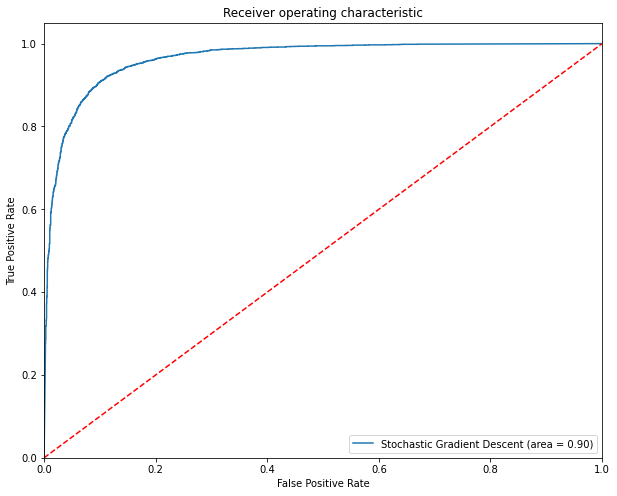

In [ ]:
logit_roc_auc = roc_auc_score(y_test, sgd_pipe.predict(X_test.review))
fpr, tpr, thresholds = roc_curve(y_test, sgd_pipe.predict_proba(X_test.review)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Stochastic Gradient Descent (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

SGD Classifier gives 0.9 accuracy score and 0.9 ROC-AUC score.  

# Naive Bayes

In [ ]:
nb_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('clf', MultinomialNB())
])

tuned_parameters = [{'clf__alpha': [0, 0.5, 1.0, 5], 'clf__fit_prior':[True, False]}]

nb_gs = GridSearchCV(nb_pipe, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [ ]:
nb_gs.fit(X_train.review, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..................clf__alpha=0, clf__fit_prior=True; total time=   8.4s
[CV] END ..................clf__alpha=0, clf__fit_prior=True; total time=   7.9s
[CV] END ..................clf__alpha=0, clf__fit_prior=True; total time=   8.0s
[CV] END .................clf__alpha=0, clf__fit_prior=False; total time=   6.9s
[CV] END .................clf__alpha=0, clf__fit_prior=False; total time=   9.3s
[CV] END .................clf__alpha=0, clf__fit_prior=False; total time=   8.1s
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time=   7.9s
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time=   7.6s
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time=   7.6s
[CV] END ...............clf__alpha=0.5, clf__fit_prior=False; total time=   7.9s
[CV] END ...............clf__alpha=0.5, clf__fit_prior=False; total time=   7.5s
[CV] END ...............clf__alpha=0.5, clf__fit_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=2,
                                                        ngram_range=(1, 2))),
                                       ('clf', MultinomialNB())]),
             param_grid=[{'clf__alpha': [0, 0.5, 1.0, 5],
                          'clf__fit_prior': [True, False]}],
             scoring='f1', verbose=2)

In [ ]:
nb_gs.best_params_

{'clf__alpha': 0.5, 'clf__fit_prior': False}

In [ ]:
y_pred = nb_gs.predict(X_test.review)

In [ ]:
accuracy_score(y_test, y_pred)

0.8875

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2954
           1       0.90      0.88      0.89      3046

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



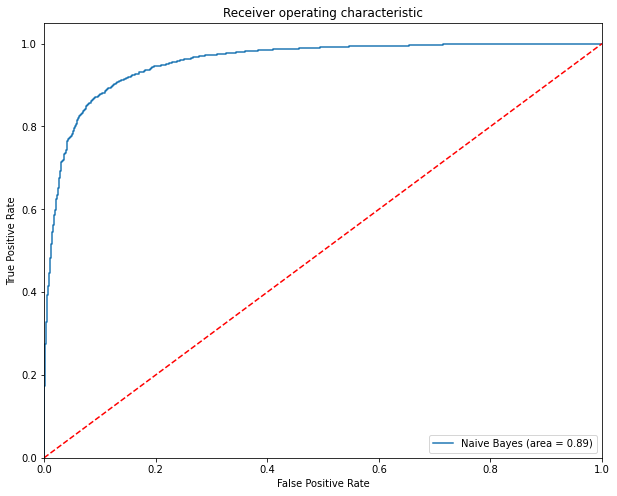

In [ ]:
logit_roc_auc = roc_auc_score(y_test, nb_gs.predict(X_test.review))
fpr, tpr, thresholds = roc_curve(y_test, nb_gs.predict_proba(X_test.review)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Got 0.89 accuracy and ROC-AUC.

# SVM

In [ ]:
svm_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('clf', SVC(max_iter=1000, probability=True))
])


tuned_parameters = [{'clf__kernel': ['rbf'], 'clf__gamma': [1e-3, 1e-4],
                     'clf__C': [1, 10]},]

svm_gs = GridSearchCV(svm_pipe, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=0, n_jobs=-1)

In [ ]:
svm_pipe.fit(X_train.review, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', SVC(max_iter=1000))])

In [ ]:
svm_gs.fit(X_train.review, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=2,
                                                        ngram_range=(1, 2))),
                                       ('clf',
                                        SVC(max_iter=1000, probability=True))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001],
                          'clf__kernel': ['rbf']}],
             scoring='f1')

In [ ]:
svm_gs.best_params_

{'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}

In [ ]:
svm_gs.score(X_train.review, y_train)

0.8275079758950727

In [ ]:
y_pred = svm_gs.predict(X_test.review)

In [ ]:
accuracy_score(y_test, y_pred)

0.7723333333333333

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.57      0.71      2954
           1       0.70      0.97      0.81      3046

    accuracy                           0.77      6000
   macro avg       0.82      0.77      0.76      6000
weighted avg       0.82      0.77      0.76      6000



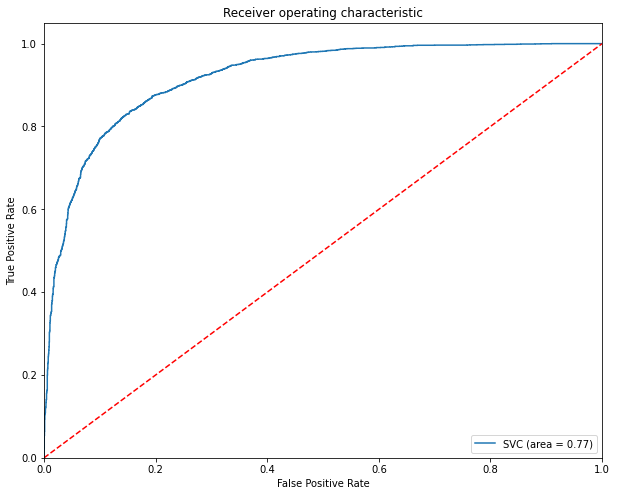

In [ ]:
logit_roc_auc = roc_auc_score(y_test, svm_gs.predict(X_test.review))
fpr, tpr, thresholds = roc_curve(y_test, svm_gs.predict_proba(X_test.review)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Got 0.77 accuracy and ROC-AUC - the lowest among all four used algorithms.

# Conclusions

In the process of completing this task, I build four different models (classifiers) in order to predict the sentiment of a movie review. The first part of this process was data exploration - obtaining descriptive statistics of the whole corpus. The next big step is a preprocessing of text data in order to prepare it for further model fitting. This includes different cleaning technics, reduction of words to their base forms, and tokenization.
Models which I trained include:
- Logistic Regression
- Stochastic Gradient Descent (SGDClassifier)
- Naive Bayes (MultinomialNB)
- SVM (SVC)  <br>   
The best results were obtained by SGDClassifier, and the worst - with SVC. SVC also shows up as the slowest algorithm among the ones used.